# - Portuguese Training Dataset -

# Imports

In [1]:
%autosave 60

Autosaving every 60 seconds


In [2]:
import pickle
from pathlib import Path
from dataclasses import dataclass, field
from tqdm import tqdm
import transformers # conda install tensorflow
#from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification
from IPython.display import display, HTML
from collections import deque
from multiprocessing import Pool
import os
from functools import partial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Needed to train the model
#from datasets import Dataset,DatasetDict
#from transformers import AutoModelForSequenceClassification,AutoTokenizer

# Read original article data (including sentences with no names in it) 

In [3]:
inputdir = Path('../ner')
filename = 'portuguese_sentences_with_names.csv'
dtype={'id':int,
       'language':str,
       'sentence':str,
       'name':str
       }

original = pd.read_csv(inputdir/filename, dtype=dtype).fillna('')
original = original.drop(columns=['language']) # drop redundant column

In [4]:
original

,id,sentence,name
0,54006424,O presidente do FC Schalke 04 e proprietário ...,Clemens Tönnies
1,54006424,O Schalke não conseguiu nenhuma vitória nos ...,
2,54006424,"A equipe dos ""azuis-reais"" terminou o campeona...",
3,54006424,A participação em uma dessas grandes competi...,
4,54006424,Tönnies foi amplamente criticado no ano passa...,
...,...,...,...
386070,54006316,Na avaliação por grupo de 100 mil habitantes...,
386071,54006316,"O Rio de Janeiro, a segunda unidade da federac...",
386072,54006316,O estado mais afetado continua sendo São Paul...,
386073,54006316,"Em números acumulados, o Brasil tem 790.040 p...",


In [5]:
original.id.unique().size

11592

# Extract full text of the articles

Concatenate the sentences in an article to extract the full text of the article all together

*Note that the data `original` may have duplucated sentences per article (when that sentence has multiple names in it). However, the sentences are still in the same order as they appear in the original text. That order is preserved when using the method `unique` of the DataFrame.

In [6]:
full_texts = original.groupby(['id']).agg({'sentence':lambda x: ' '.join(x.unique())})
full_texts = full_texts.rename(columns = {'sentence':'full_text'})
full_texts = full_texts.reset_index()

In [7]:
full_texts

,id,full_text
0,36728631,"Muitas pessoas, frequentemente trabalhando em ..."
1,51740080,Com o objetivo de ampliar sua presença na Ama...
2,51846913,"""O populista Donald Trump e o extremista de di..."
3,51850454,"Quando Jair Messias Bolsonaro recebeu, no dia ..."
4,51850907,Um incêndio na madrugada desta quarta-feira (...
...,...,...
11587,62461355,A comissão parlamentar que investiga a invasa...
11588,62461496,"O Congresso derrubou, nesta terça-feira (12/7..."
11589,62462074,Dias antes da visita do presidente dos Estados...
11590,62463146,O governo da Hungriadeclarou nesta quarta-feir...


## Explore the data

In [10]:
full_texts['article_length'] = full_texts.full_text.apply(len)

In [11]:
full_texts.article_length.describe()

count    11592.000000
mean      4447.650362
std       2675.679618
min         39.000000
25%       2789.000000
50%       3910.000000
75%       5485.000000
max      68140.000000
Name: article_length, dtype: float64

<AxesSubplot:>

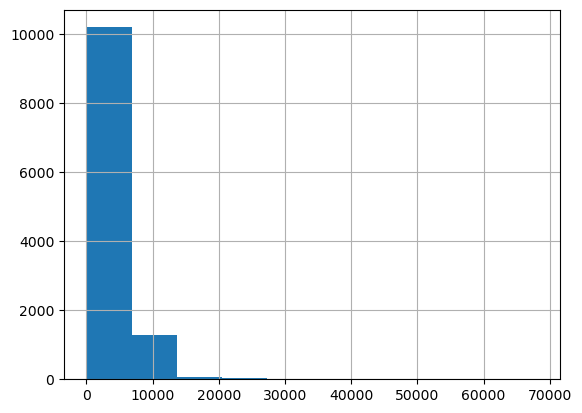

In [12]:
full_texts.article_length.hist()

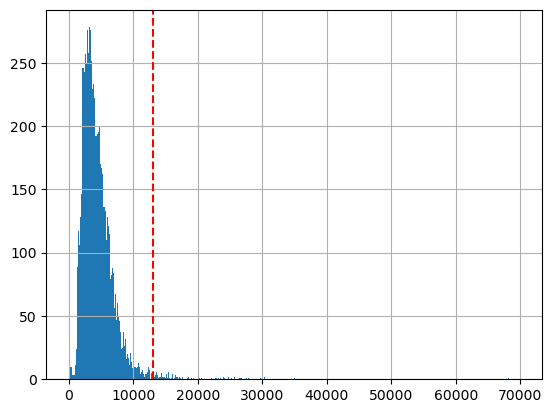

In [13]:
fig, ax = plt.subplots()
bins=np.arange(0,70_000,100)
full_texts.article_length.hist(bins=bins, ax=ax)

too_long_article = 13_000
ax.axvline(too_long_article, color='r', ls='--')

## Remove too long and too short articles (outliers)

In [14]:
full_texts.article_length.describe()

count    11592.000000
mean      4447.650362
std       2675.679618
min         39.000000
25%       2789.000000
50%       3910.000000
75%       5485.000000
max      68140.000000
Name: article_length, dtype: float64

In [15]:
full_texts = full_texts.query('article_length<=@too_long_article')

In [16]:
full_texts.article_length.describe()

count    11455.000000
mean      4276.534177
std       2037.210100
min         39.000000
25%       2772.500000
50%       3885.000000
75%       5407.000000
max      12992.000000
Name: article_length, dtype: float64

<AxesSubplot:>

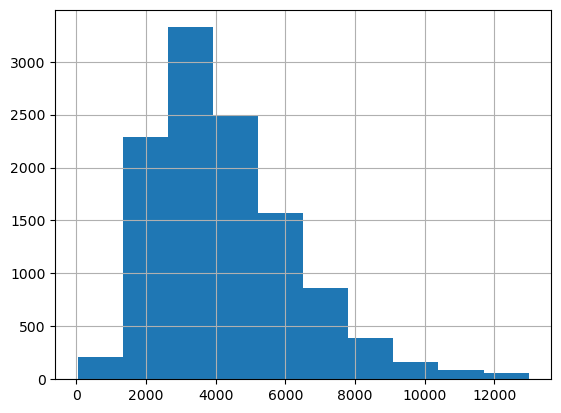

In [17]:
full_texts.article_length.hist()

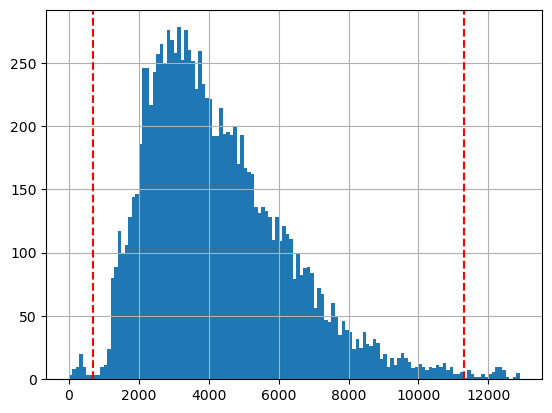

In [18]:
fig, ax = plt.subplots()
bins=np.arange(0,13_000,100)
full_texts.article_length.hist(bins=bins, ax=ax)

too_long_article = 11_300
too_short_article = 700
ax.axvline(too_long_article, color='r', ls='--')
ax.axvline(too_short_article, color='r', ls='--')

In [19]:
full_texts.article_length.describe()

count    11455.000000
mean      4276.534177
std       2037.210100
min         39.000000
25%       2772.500000
50%       3885.000000
75%       5407.000000
max      12992.000000
Name: article_length, dtype: float64

In [20]:
full_texts = full_texts.query('article_length<=@too_long_article and article_length>=@too_short_article')

In [21]:
full_texts.article_length.describe()

count    11328.000000
mean      4247.703302
std       1931.994134
min        727.000000
25%       2783.750000
50%       3882.000000
75%       5383.250000
max      11293.000000
Name: article_length, dtype: float64

<AxesSubplot:>

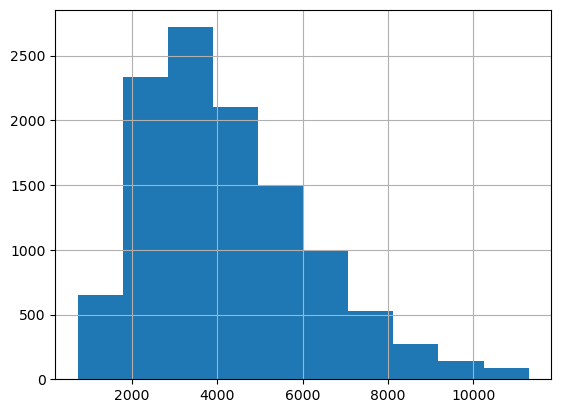

In [22]:
full_texts.article_length.hist()

<AxesSubplot:>

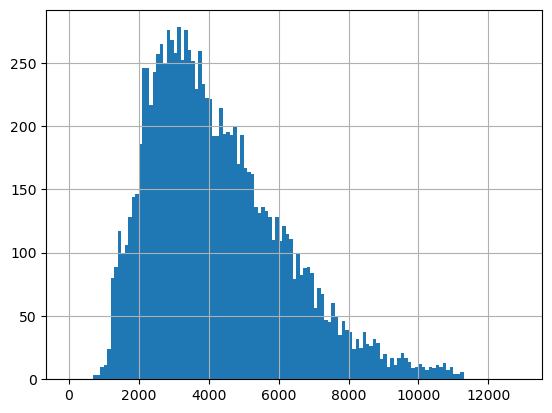

In [23]:
fig, ax = plt.subplots()
bins=np.arange(0,13_000,100)
full_texts.article_length.hist(bins=bins, ax=ax)

# Read Wikipedia results

This are the results from the Wikipedia query. The input for the query was the following file `portuguese_articles_and_names_v3.csv`. **Note that later, a new version of the Wikipedia query was developed and I did not have time to create a new training dataset using that lasted version**.

In [18]:
inputdir = Path.cwd()
filename = Path('Wikiresults.csv')
wikidata = pd.read_csv(inputdir/filename, usecols=['id', 'name', 'results_Wikipedia'])

Take a look at it

In [19]:
wikidata

,id,name,results_Wikipedia
0,54006424,Clemens Tönnies,False
1,54006424,Gerald Asamoah,MALE
2,54006424,Hans Sarpei,MALE
3,54006424,Cacau,MALE
4,54003004,Angela Merkel,FEMALE
...,...,...,...
57264,54006072,Paulo,MALE
57265,54006072,Anderson Correia,False
57266,54006072,Renato Feder,False
57267,54006072,Sérgio,False


See its information

In [27]:
wikidata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57269 entries, 0 to 57268
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 57269 non-null  int64 
 1   name               57269 non-null  object
 2   results_Wikipedia  57269 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


Describe some columns

In [28]:
wikidata.describe(include=['object'])

,name,results_Wikipedia
count,57269,57269
unique,22171,4
top,Jair Bolsonaro,False
freq,2003,29229


Check how many unique articles are there

In [21]:
wikidata.id.unique().size

10541

Check how many unique labels are there

In [22]:
wikidata.results_Wikipedia.value_counts()

False     29229
MALE      23121
FEMALE     4912
NB            7
Name: results_Wikipedia, dtype: int64

Check how many names per article

In [31]:
wikidata_grouped_by_article = wikidata.groupby(['id']).agg({'name':lambda x: len(x)})

In [32]:
wikidata_grouped_by_article.head()

,name
id,
36728631,8
51740080,6
51846913,7
51850454,8
51850907,1


In [33]:
wikidata_grouped_by_article.name.describe()

count    10541.000000
mean         5.432976
std          4.408547
min          1.000000
25%          2.000000
50%          4.000000
75%          7.000000
max         79.000000
Name: name, dtype: float64

<AxesSubplot:>

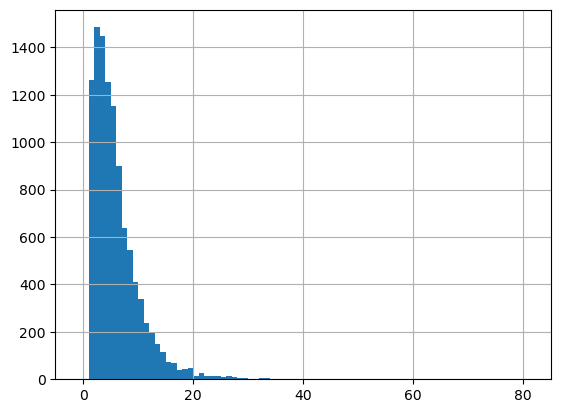

In [34]:
bins = np.arange(-1,82)
wikidata_grouped_by_article.name.hist(bins=bins)

<AxesSubplot:>

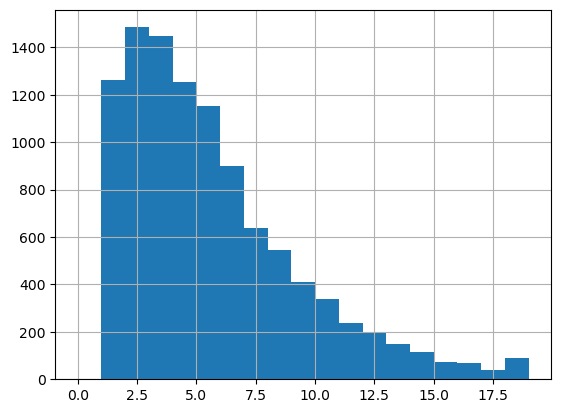

In [35]:
bins = np.arange(0,20)
wikidata_grouped_by_article.name.hist(bins=bins)

# Remove from the data the names that were not labelled as `female` or `male`

## Take a look at the labels to remove

In [36]:
wikidata.query('results_Wikipedia=="NB"')

,id,name,results_Wikipedia
2848,54623961,Anuna De Wever,NB
12371,56283936,Demi Lovato,NB
27615,61271968,Sam Smith,NB
36301,58614355,Sam Smith,NB
39491,59148135,Judith Butler,NB
46219,51906971,Rose McGowan,NB
50325,52727890,Rose McGowan,NB


In [37]:
wikidata.query('results_Wikipedia=="False"')

,id,name,results_Wikipedia
0,54006424,Clemens Tönnies,False
11,54009380,Lícia D ́Ávila,False
19,54009331,Mark Milley,False
20,54009331,Jonathan Hoffman,False
22,54009331,Peter Bayer,False
...,...,...,...
57261,54006072,Franco Bartolacci,False
57262,54006072,Thomas Conti,False
57265,54006072,Anderson Correia,False
57266,54006072,Renato Feder,False


## Take a look to the label `"False"`

In [38]:
not_found_in_wikipedia = wikidata.query('results_Wikipedia=="False"')

In [39]:
not_found_in_wikipedia_grouped_by_article = not_found_in_wikipedia.groupby(['id']).agg({'name':lambda x: len(x)})

In [40]:
not_found_in_wikipedia_grouped_by_article.head()

,name
id,
36728631,3
51740080,4
51846913,2
51850454,3
51850907,1


In [41]:
not_found_in_wikipedia_grouped_by_article.name.describe()

count    9143.000000
mean        3.196872
std         2.504112
min         1.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        49.000000
Name: name, dtype: float64

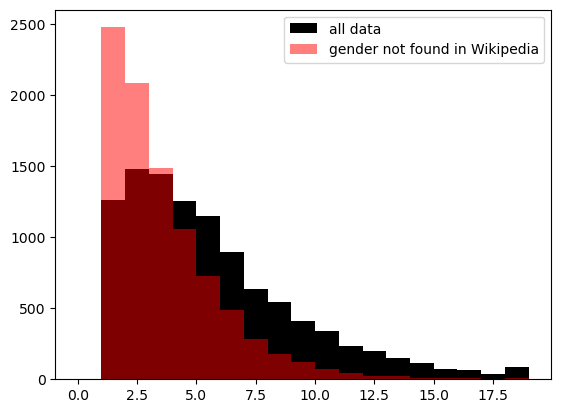

In [42]:
fig, ax = plt.subplots()
bins = np.arange(0,20)
wikidata_grouped_by_article.name.hist(bins=bins, ax=ax, label='all data', alpha=1.0, color='k', grid=False)
not_found_in_wikipedia_grouped_by_article.name.hist(bins=bins, ax=ax, label='gender not found in Wikipedia', alpha=0.5, color='r', grid=False)
plt.legend()

Remove those labels

In [43]:
lst = ['NB', 'False'] # labels to remove

In [44]:
new_wikidata = wikidata.query('results_Wikipedia not in @lst')

Take a look at it

In [45]:
new_wikidata

,id,name,results_Wikipedia
1,54006424,Gerald Asamoah,MALE
2,54006424,Hans Sarpei,MALE
3,54006424,Cacau,MALE
4,54003004,Angela Merkel,FEMALE
5,54003004,Emmanuel Macron,MALE
...,...,...,...
57259,54006072,Abraham Weintraub,MALE
57260,54006072,Carlos Alberto Decotelli da Silva,MALE
57263,54006072,Lattes,MALE
57264,54006072,Paulo,MALE


See its information

In [46]:
new_wikidata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28033 entries, 1 to 57268
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 28033 non-null  int64 
 1   name               28033 non-null  object
 2   results_Wikipedia  28033 non-null  object
dtypes: int64(1), object(2)
memory usage: 876.0+ KB


Describe some columns

In [47]:
new_wikidata.describe(include=['object'])

,name,results_Wikipedia
count,28033,28033
unique,5218,2
top,Jair Bolsonaro,MALE
freq,2003,23121


Check how many unique articles are there

In [48]:
new_wikidata.id.unique().size

8492

Check how many unique labels are there

In [49]:
new_wikidata.results_Wikipedia.value_counts()

MALE      23121
FEMALE     4912
Name: results_Wikipedia, dtype: int64

Check how many names per article

In [50]:
new_wikidata_grouped_by_article = new_wikidata.groupby(['id']).agg({'name':lambda x: len(x)})

In [51]:
new_wikidata_grouped_by_article.head()

,name
id,
36728631,5
51740080,2
51846913,5
51850454,5
51851186,1


In [52]:
new_wikidata_grouped_by_article.name.describe()

count    8492.000000
mean        3.301107
std         2.826492
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        33.000000
Name: name, dtype: float64

<AxesSubplot:>

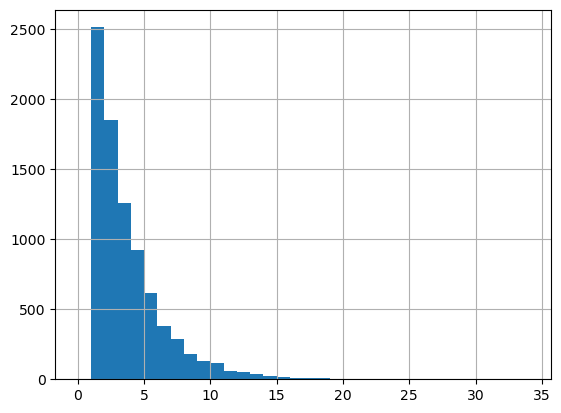

In [53]:
bins = np.arange(0,35)
new_wikidata_grouped_by_article.name.hist(bins=bins)

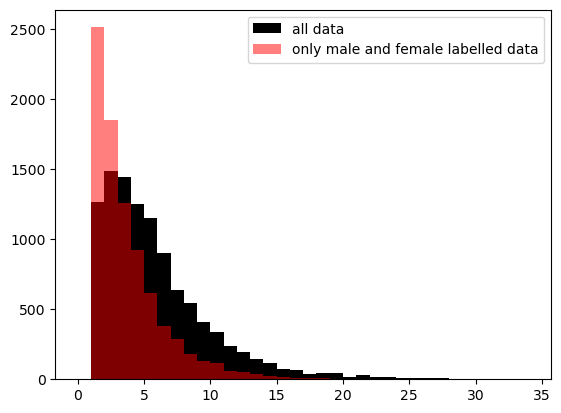

In [54]:
fig, ax = plt.subplots()
bins = np.arange(0,35)
wikidata_grouped_by_article.name.hist(bins=bins, ax=ax, label='all data', alpha=1.0, color='k', grid=False)
new_wikidata_grouped_by_article.name.hist(bins=bins, ax=ax, label='only male and female labelled data', alpha=0.5, color='r', grid=False)
plt.legend()

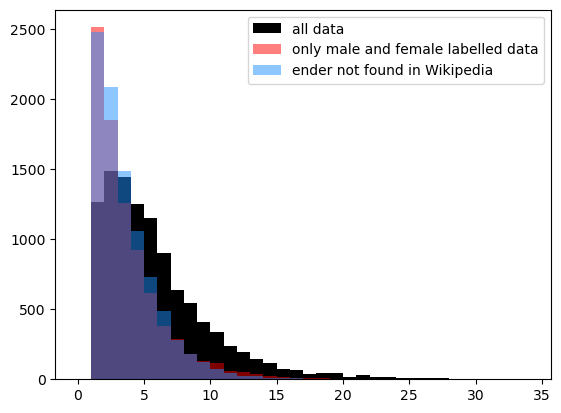

In [55]:
fig, ax = plt.subplots()
bins = np.arange(0,35)
wikidata_grouped_by_article.name.hist(bins=bins, ax=ax, label='all data', alpha=1.0, color='k', grid=False)
new_wikidata_grouped_by_article.name.hist(bins=bins, ax=ax, label='only male and female labelled data', alpha=0.5, color='r', grid=False)
not_found_in_wikipedia_grouped_by_article.name.hist(bins=bins, ax=ax, label='ender not found in Wikipedia', alpha=0.5, color='dodgerblue', grid=False)
plt.legend()

It makes sense that, if the most likely value in red and blue is 1, then, because black is the union, the most likely value moves to the right.

-> If most of the unknown names happen alone in an article (blue), and most gendered names happen alone in an article (red), then the histogram tell us that most likely there are many articles that contain one gendered name and one unknown name.

In [56]:
wikidata = new_wikidata
wikidata_grouped_by_article = new_wikidata_grouped_by_article

# Remove articles with too many names in it (outliers)

## Take a look at the data

In [57]:
wikidata

,id,name,results_Wikipedia
1,54006424,Gerald Asamoah,MALE
2,54006424,Hans Sarpei,MALE
3,54006424,Cacau,MALE
4,54003004,Angela Merkel,FEMALE
5,54003004,Emmanuel Macron,MALE
...,...,...,...
57259,54006072,Abraham Weintraub,MALE
57260,54006072,Carlos Alberto Decotelli da Silva,MALE
57263,54006072,Lattes,MALE
57264,54006072,Paulo,MALE


See its information

In [58]:
wikidata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28033 entries, 1 to 57268
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 28033 non-null  int64 
 1   name               28033 non-null  object
 2   results_Wikipedia  28033 non-null  object
dtypes: int64(1), object(2)
memory usage: 876.0+ KB


Describe some columns

In [59]:
wikidata.describe(include=['object'])

,name,results_Wikipedia
count,28033,28033
unique,5218,2
top,Jair Bolsonaro,MALE
freq,2003,23121


Check how many unique articles are there

In [60]:
wikidata.id.unique().size

8492

Check how many unique labels are there

In [61]:
wikidata.results_Wikipedia.value_counts()

MALE      23121
FEMALE     4912
Name: results_Wikipedia, dtype: int64

Check how many names per article

In [62]:
wikidata_grouped_by_article = new_wikidata.groupby(['id']).agg({'name':lambda x: len(x)})

In [63]:
wikidata_grouped_by_article.head()

,name
id,
36728631,5
51740080,2
51846913,5
51850454,5
51851186,1


In [64]:
wikidata_grouped_by_article.name.describe()

count    8492.000000
mean        3.301107
std         2.826492
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        33.000000
Name: name, dtype: float64

<AxesSubplot:>

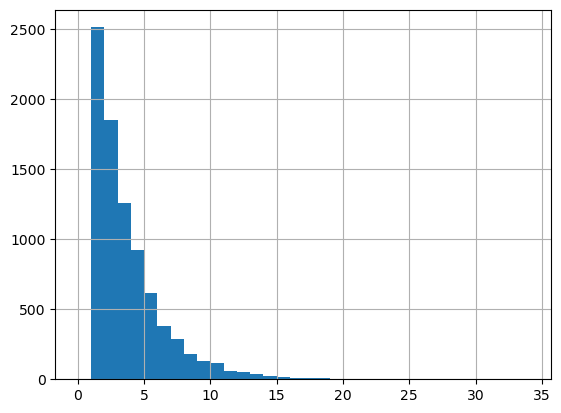

In [65]:
bins = np.arange(0,35)
wikidata_grouped_by_article.name.hist(bins=bins)

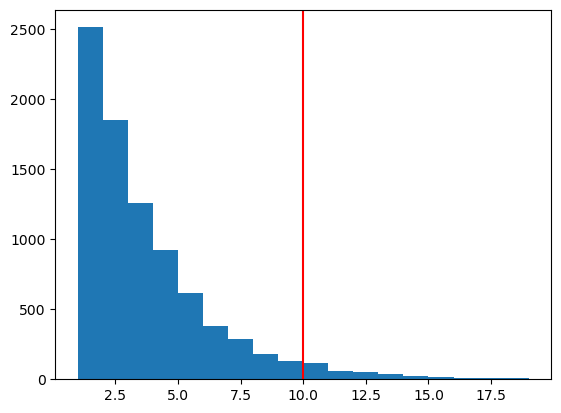

In [66]:
fig, ax = plt.subplots()
bins = np.arange(1,20)
wikidata_grouped_by_article.name.hist(bins=bins, ax=ax, grid=False)

# Outliers (tail of the distribution)
too_many_names = 10
ax.axvline(too_many_names, color='r')

## Remove outliers

Let's only keep articles with up to 10 names in it.

In [67]:
article_ids = wikidata_grouped_by_article.query('name>@too_many_names').index.tolist()

Number of articles to remove

In [68]:
len(article_ids)

234

Check the number or articles before removing articles

In [69]:
wikidata.id.unique().size

8492

Remove articles

In [70]:
wikidata = wikidata.query('id not in @article_ids').reset_index(drop=True)

Check the number or articles after removing articles

In [71]:
wikidata.query('id not in @article_ids').id.unique().size

8258

Check how many names per article after removing articles

In [72]:
wikidata_grouped_by_article = wikidata.groupby(['id']).agg({'name':lambda x: len(x)})

In [73]:
wikidata_grouped_by_article.name.describe()

count    8258.000000
mean        3.001938
std         2.144133
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        10.000000
Name: name, dtype: float64

<AxesSubplot:>

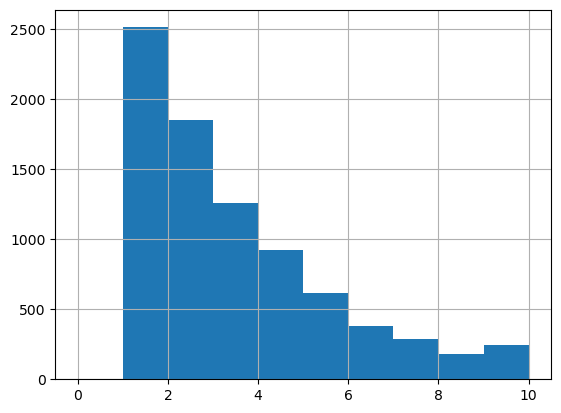

In [74]:
bins = np.arange(0,11)
wikidata_grouped_by_article.name.hist(bins=bins)

# Separate male and female 

## Check the data

In [75]:
wikidata.describe(include=['object'])

,name,results_Wikipedia
count,24790,24790
unique,4620,2
top,Jair Bolsonaro,MALE
freq,1863,20458


Check how many unique articles are there

In [76]:
wikidata.id.unique().size

8258

Check how many unique labels are there

In [77]:
wikidata.results_Wikipedia.value_counts()

MALE      20458
FEMALE     4332
Name: results_Wikipedia, dtype: int64

## Check that the original data has all nedeed articles

In [82]:
print(set(wikidata.id)-set(full_texts.id))

{53492736, 53266434, 61274631, 58053132, 57778205, 57850399, 57007647, 57114146, 59311139, 61737516, 61104687, 62378032, 61971507, 58619955, 57282101, 57607735, 53584442, 55686715, 60046906, 55372348, 54261829, 61090377, 57421386, 57686090, 61141065, 53016139, 53002321, 53057107, 56538195, 61421652, 61455444, 53446236, 53860455, 59116137, 59002478, 53229686, 56164471, 52104312, 53505144, 55192189, 61966973, 53021311, 61059712, 58180735, 59562113, 56486527, 52345476, 56380548, 59801738, 61157517, 62141583, 59310741, 53195927, 56069787, 58902685, 52407978, 59014829, 58131633, 54594738, 59927221, 55677629, 52559550, 61523138, 56275139, 57455302, 52949702, 53178569, 59454162, 61135058, 57822934, 58144471, 57305815, 58785495, 54036186, 56059612, 55208669, 58784481, 53596389, 53072617, 57053419, 56968428, 56753900, 56292590, 57969917, 59429631, 59331842, 59782404, 57919755, 52977939, 56890646, 52964630, 62213399, 62121755, 62055196, 53310236, 55490847, 57081125, 54528808, 56938280, 57653548,

In [83]:
article_in_wikipedia_not_in_original = set(wikidata.id)-set(full_texts.id)

In [84]:
len(article_in_wikipedia_not_in_original)

169

## Remove articles from the Wikipedia set that are not in the original anymore

In [90]:
wikidata.id.unique().size

8258

In [93]:
wikidata = wikidata.query('id not in @article_in_wikipedia_not_in_original')

In [94]:
wikidata.id.unique().size

8089

## Separate M and F

In [95]:
wikidata_M = wikidata.query('results_Wikipedia=="MALE"')

In [96]:
wikidata_F = wikidata.query('results_Wikipedia=="FEMALE"')

In [97]:
wikidata_M.head(10)

,id,name,results_Wikipedia
0,54006424,Gerald Asamoah,MALE
1,54006424,Hans Sarpei,MALE
2,54006424,Cacau,MALE
4,54003004,Emmanuel Macron,MALE
5,54003004,Olaf Scholz,MALE
6,54003004,Alexander Hamilton,MALE
9,54003004,Robert Schuman,MALE
10,54009380,James Webb,MALE
11,54008153,Xi Jinping,MALE
12,54008153,Zhang Xiaoming,MALE


In [100]:
wikidata_F.head(10)

,id,name,results_Wikipedia
3,54003004,Angela Merkel,FEMALE
7,54003004,Christine Lagarde,FEMALE
8,54003004,Ursula von der Leyen,FEMALE
13,54008153,Carrie Lam,FEMALE
18,54009331,Angela Merkel,FEMALE
28,54019162,Angela Merkel,FEMALE
31,54020046,Yalitza Aparicio,FEMALE
32,54020046,Eva Longoria,FEMALE
33,54020046,Awkwafina,FEMALE
34,54020046,Zendaya,FEMALE


# Create training data (includes validation) and test data

## Check data

### All

In [101]:
wikidata.describe(include=['object'])

,name,results_Wikipedia
count,23892,23892
unique,4538,2
top,Jair Bolsonaro,MALE
freq,1773,19714


Check how many unique articles are there

In [102]:
wikidata.id.unique().size

8089

Check how many unique labels are there

In [103]:
wikidata.results_Wikipedia.value_counts()

MALE      19714
FEMALE     4178
Name: results_Wikipedia, dtype: int64

### Female

In [124]:
wikidata_F

,id,name,results_Wikipedia
3,54003004,Angela Merkel,FEMALE
7,54003004,Christine Lagarde,FEMALE
8,54003004,Ursula von der Leyen,FEMALE
13,54008153,Carrie Lam,FEMALE
18,54009331,Angela Merkel,FEMALE
...,...,...,...
24758,53985315,Angela Merkel,FEMALE
24770,53995146,Camila,FEMALE
24771,54005186,Carrie Lam,FEMALE
24781,54005845,Ursula von der Leyen,FEMALE


In [104]:
wikidata_F.describe(include=['object'])

,name,results_Wikipedia
count,4178,4178
unique,982,1
top,Angela Merkel,FEMALE
freq,823,4178


Check how many unique articles are there

In [105]:
wikidata_F.id.unique().size

3050

Check how many names per article after removing articles

In [106]:
wikidata_F_grouped_by_article = wikidata_F.groupby(['id']).agg({'name':lambda x: len(x)})

In [107]:
wikidata_F_grouped_by_article.name.describe()

count    3050.000000
mean        1.369836
std         0.747758
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         8.000000
Name: name, dtype: float64

<AxesSubplot:>

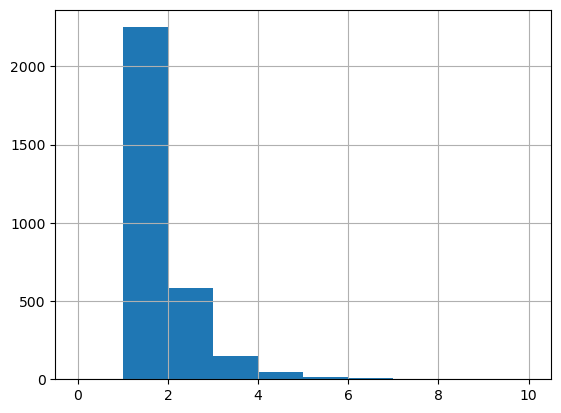

In [108]:
bins = np.arange(0,11)
wikidata_F_grouped_by_article.name.hist(bins=bins)

### Male

In [109]:
wikidata_M.describe(include=['object'])

,name,results_Wikipedia
count,19714,19714
unique,3556,1
top,Jair Bolsonaro,MALE
freq,1773,19714


Check how many unique articles are there

In [110]:
wikidata_M.id.unique().size

7440

Check how many names per article after removing articles

In [111]:
wikidata_M_grouped_by_article = wikidata_M.groupby(['id']).agg({'name':lambda x: len(x)})

In [112]:
wikidata_M_grouped_by_article.name.describe()

count    7440.000000
mean        2.649731
std         1.833989
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        10.000000
Name: name, dtype: float64

<AxesSubplot:>

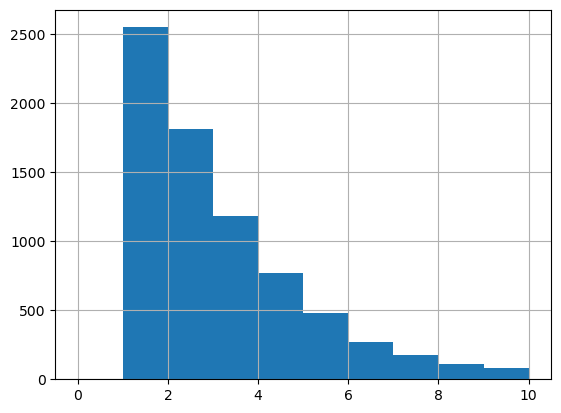

In [113]:
bins = np.arange(0,11)
wikidata_M_grouped_by_article.name.hist(bins=bins)

### Both <a id='histogram1'></a>

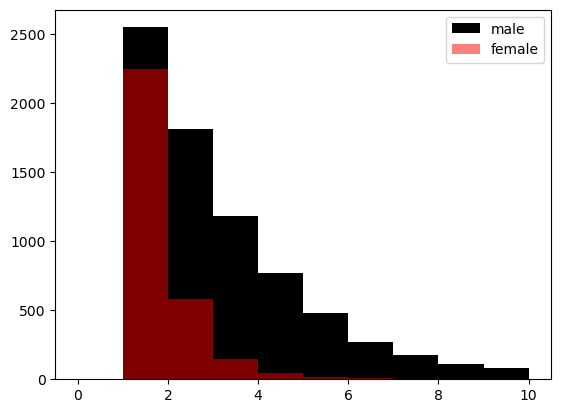

In [114]:
fig, ax = plt.subplots()
wikidata_M_grouped_by_article.name.hist(bins=bins, ax=ax, label='male', color='k', grid=False, alpha=1.0)
wikidata_F_grouped_by_article.name.hist(bins=bins, ax=ax, label='female', color='r', grid=False, alpha=0.5)
plt.legend()

Most articles have only one female name or male name.

*Note that we are not plotting the potential case of an article containing at the same time a female name and another male name. This is because we are plotting female and male dataset separate

Articles that contain two male names are more common than articles that contain two female names. Same applyes for number larger than two.

## Trainig set (includes validation set)

In [115]:
size_of_training_set = 4_000 # including validation set
males_data = wikidata_M.sample(size_of_training_set, random_state=0)
females_data = wikidata_F.sample(size_of_training_set, random_state=1)

In [116]:
males_data

,id,name,results_Wikipedia
104,54044754,Michael Ryan,MALE
10553,60667556,Joe Biden,MALE
5872,56482283,Eduardo Pazuello,MALE
2079,55004246,Gavin Newsom,MALE
19258,60035292,Wolfgang Schmidt,MALE
...,...,...,...
13033,61634450,Jens Stoltenberg,MALE
17125,59149356,Donald Trump,MALE
23606,53551482,Celso de Mello,MALE
10886,60800766,Ricardo Salles,MALE


In [118]:
females_data

,id,name,results_Wikipedia
62,54033786,Ghislaine Maxwell,FEMALE
22026,52812549,Sara Johnson,FEMALE
20553,52134915,Sonia Guajajara,FEMALE
12607,61478126,Marine Le Pen,FEMALE
18411,59644426,Raquel Dodge,FEMALE
...,...,...,...
8894,57801614,Angela Merkel,FEMALE
8236,57473056,Ursula von der Leyen,FEMALE
20680,52192476,Ursula von der Leyen,FEMALE
8235,57473056,Angela Merkel,FEMALE


Check that the sample was done without replacement

In [117]:
males_data.index.unique().size

4000

In [119]:
females_data.index.unique().size

4000

Check the number of unique articles

In [120]:
males_data.id.unique().size

3071

In [121]:
females_data.id.unique().size

2948

In [122]:
males_data_grouped_by_article = males_data.groupby(['id']).agg({'name':lambda x: len(x)})
females_data_grouped_by_article = females_data.groupby(['id']).agg({'name':lambda x: len(x)})

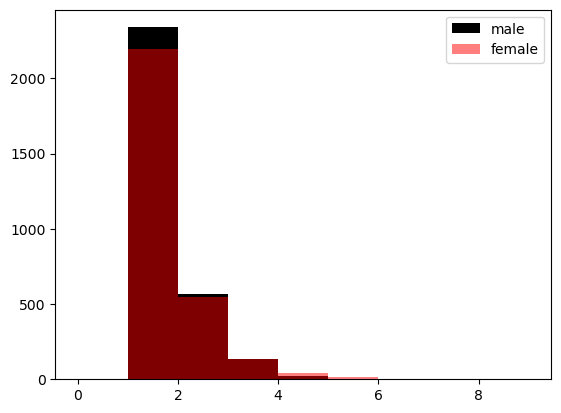

In [123]:
fig, ax = plt.subplots()
bins = np.arange(0,10)
males_data_grouped_by_article.name.hist(bins=bins, ax=ax, label='male', color='k', grid=False, alpha=1.0)
females_data_grouped_by_article.name.hist(bins=bins, ax=ax, label='female', color='r', grid=False, alpha=0.5)
plt.legend()

**Why** do the two histograms above look the same given that that data (`males_data` and `females_data`) comes from `wikidata_M` and `wikidata_F` [whose equivalent histograms look different from each other](#histogram1)?

First, note that the histograms are not about `males_data` and `females_data` or `wikidata_M` and `wikidata_F`. The histograms are about their gropued version (grouped by article or `id` column). However, the question remains: why the histograms of the groped version for `males_data` and `females_data` are different from th grouped version for `wikidata_M` and `wikidata_F`?

The reason is the sample that creates `males_data` samples from the rows of `wikidata_M`, i.e., takes random names and not articles. Then, it is less likely to randomly pick names that come from the same article: thera are 7.5k articles and 20k names. In addition, most articles only have one male name in it, as shown in [this histogram](#histogram1). Then it is natural that the histogram of the gruped version of `males_data`  is more skewed towards 1 than the histogram about the grouped version of `wikidata_M`.

## Test set 

This set will not take part in the training scheme. It will be kept separate to prevent from being potentialy corrupted by the training scheme.

To create this set, we will use the elements from `wikidata_M` and `wikidata_F` that did not go to `male_data` and `female_data`.

In [128]:
wikidata_F.query('index not in @females_data.index')

,id,name,results_Wikipedia
50,54027541,Valentina Tereshkova,FEMALE
94,54037037,Rosa Weber,FEMALE
443,54213833,Mary Trump,FEMALE
555,54257046,Cyndi Lauper,FEMALE
908,54489955,Michelle Bolsonaro,FEMALE
...,...,...,...
24450,53854813,Angela Merkel,FEMALE
24475,53860884,Dilma Rousseff,FEMALE
24549,53892063,Alexandria Ocasio - Cortez,FEMALE
24594,53916411,Dilma Rousseff,FEMALE


Because only remain 178 elements in `wikidata_F`, then the test data set will be of that size for male and female

In [129]:
size_of_test_set = 178

In [130]:
_ = wikidata_M.query('index not in @males_data.index')
males_test = _.sample(size_of_test_set, random_state=3)

In [131]:
_ = wikidata_F.query('index not in @females_data.index')
females_test = _.sample(size_of_test_set, random_state=4)

Check that the sample was done without replacement

In [132]:
males_test.index.unique().size

178

In [133]:
females_test.index.unique().size

178

Check the number of unique articles

In [134]:
males_test.id.unique().size

176

In [135]:
females_test.id.unique().size

175

In [136]:
males_test_grouped_by_article = males_test.groupby(['id']).agg({'name':lambda x: len(x)})
females_test_grouped_by_article = females_test.groupby(['id']).agg({'name':lambda x: len(x)})

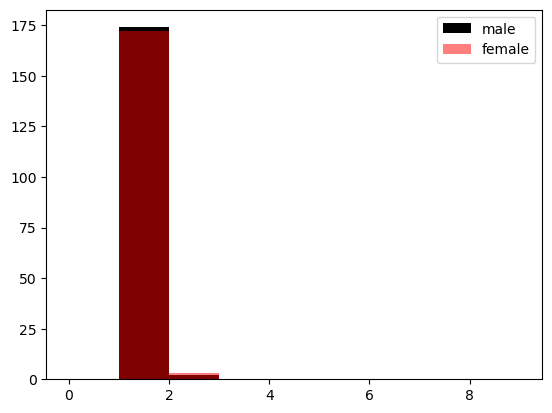

In [137]:
fig, ax = plt.subplots()
bins = np.arange(0,10)
males_test_grouped_by_article.name.hist(bins=bins, ax=ax, label='male', color='k', grid=False, alpha=1.0)
females_test_grouped_by_article.name.hist(bins=bins, ax=ax, label='female', color='r', grid=False, alpha=0.5)
plt.legend()

# Save status

In [138]:
outputdir = Path.cwd()
file = 'names_and_articles_to_use_as_training_and_test_sets.pickle'
with open(outputdir/file, 'wb') as file:
    pickle.dump({'males_test':males_test,
                 'females_test':females_test,
                 'males_data':males_data,
                 'females_data':females_data}, file)

# Read training dataset (including validation) and test dataset

In [145]:
inputdir = Path.cwd()
file = 'names_and_articles_to_use_as_training_and_test_sets.pickle'
with open(inputdir/file, 'rb') as file:
    tmp = pickle.load(file)

In [146]:
# Test dataset
males_test = tmp['males_test']
females_test = tmp['females_test']

# training dataset (including validation dataset)
males_data = tmp['males_data']
females_data = tmp['females_data']

In [147]:
males_data.head()

,id,name,results_Wikipedia
104,54044754,Michael Ryan,MALE
10553,60667556,Joe Biden,MALE
5872,56482283,Eduardo Pazuello,MALE
2079,55004246,Gavin Newsom,MALE
19258,60035292,Wolfgang Schmidt,MALE


Take a look at it

In [148]:
males_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 104 to 24472
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 4000 non-null   int64 
 1   name               4000 non-null   object
 2   results_Wikipedia  4000 non-null   object
dtypes: int64(1), object(2)
memory usage: 125.0+ KB


In [149]:
males_data.describe(include=['object'])

,name,results_Wikipedia
count,4000,4000
unique,1278,1
top,Jair Bolsonaro,MALE
freq,383,4000


Unique number of articles

In [150]:
males_data.id.unique().size

3071

## Check that the original data has all nedeed articles [subject to change]

In [154]:
print(set(males_data.id)-set(full_texts.id))
print(set(females_data.id)-set(full_texts.id))
print(set(males_test.id)-set(full_texts.id))
print(set(females_test.id)-set(full_texts.id))

set()
set()
set()
set()


# Add the full-text information to the data sets

In [168]:
males_data_with_text = pd.merge(males_data, full_texts, how='inner', on=['id'])
females_data_with_text = pd.merge(females_data, full_texts, how='inner', on=['id'])

males_test_with_text = pd.merge(males_test, full_texts, how='inner', on=['id'])
females_test_with_text = pd.merge(females_test, full_texts, how='inner', on=['id'])

# Generate the final data sets 

Let us concatenate the male and female data and then shuffle it.

In [218]:
data = pd.concat([males_data_with_text,females_data_with_text]).sample(frac=1, random_state=6).reset_index(drop=True)

In [220]:
test_data = pd.concat([males_test_with_text,females_test_with_text]).sample(frac=1, random_state=7).reset_index(drop=True)

In [221]:
data

,id,name,results_Wikipedia,full_text,article_length
0,54153414,Andrzej Duda,MALE,A comissão eleitoral da Polônia anunciou nes...,3212
1,55253572,Erich Honecker,MALE,"Natural e casual, elegantemente trajando ócul...",6176
2,58168985,Chris Whitty,FEMALE,Apesar do número crescente de casos de covid-...,6698
3,53821497,Luiz Henrique Mandetta,MALE,"A Food and Drug Administration (FDA), agência...",4231
4,57170897,Angela Merkel,FEMALE,O populismo de direita alemão deu um passo ma...,5739
...,...,...,...,...,...
7995,61292150,Dilma Rousseff,FEMALE,Trata-se de um movimento iniciado nos anos 199...,5039
7996,60338691,Thomas Mann,MALE,"A bordo de jet-skis, os homens avançam velozm...",4515
7997,57352798,Donald Trump,MALE,Os desenvolvedores da vacina russa contra covi...,4274
7998,61662604,Bolsonaro,MALE,Durante o governo do ex-presidente americano D...,9438


In [222]:
test_data

,id,name,results_Wikipedia,full_text,article_length
0,54523862,Svetlana Tikhanovskaya,FEMALE,O ministro das Relações Exteriores da Lituâ...,6318
1,57725423,Frank - Walter Steinmeier,MALE,"Novas revelações, feitas neste domingo (30/0...",1988
2,58283114,Cristiano Carvalho,FEMALE,"O representante da Davati Medical Supply, Cris...",7654
3,60084542,Joe Biden,MALE,"A partir deste sábado (11/12), brasileiros qu...",8205
4,62366291,Ann Linde,FEMALE,Embaixadores dos 30 países-membros da Otan as...,2248
...,...,...,...,...,...
351,58817709,Anne,FEMALE,"Nascida em Teresina, Piauí, Mary Lages nunca ...",5475
352,57146763,Recep Tayyip Erdogan,MALE,"O primeiro-ministro italiano, Mario Draghi, ch...",2750
353,55374814,Francisco,MALE,"Sete anos mais tarde, ele redobra a carga. No ...",4451
354,58242406,Maria Van Kerkhove,FEMALE,A Organização Mundial da Saúde (OMS) expres...,4030


# Save

In [227]:
outputdir = Path.cwd()
filename = Path('portuguese_training_data_v2.csv')
data.to_csv(outputdir/filename, index=False)

In [228]:
outputdir = Path.cwd()
filename = Path('portuguese_test_data_v2.csv')
test_data.to_csv(outputdir/filename, index=False)